<a href="https://colab.research.google.com/github/samarakoon-ryan/NASANearestEarthObjectsModeling/blob/initial-model/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predicting Nearest Earth Objects using NASA Dataset




## Background

Outer Space is vast and the number of foreign objects in space is infinite. The distances in space are numbers we cannot fathom, but NASA considers objects within 70,000 Km of Earth as Nearest Earth Objects. These objects or asteroids can be dangerous to Earth and NASA constantly monitors various parameters of these asteroids. Considering the large amount of data available on the current nearest earth objects, it would be useful to use the various parameters of these data to predict whether a nearest earth object is of any concern to Earth.

## Project Description

The NASA Nearest Earth Objects dataset includes over 90,000 datapoints on asteroids. These datapoints include distance, velocity, magnitude, and diameter among other things. All datapoints are also labeled with a boolean value for whether the asteroid is considered hazardous to Earth or not. After some cleaning and feature engineering, I plan to use 10,000 datapoints as a training dataset and another 10,000 datapoints as the test dataset. The test dataset will not include the "hazardous" column as this is what I'll be planning to predict based on the other columns.

Dataset Source - https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects


### Basic Exploratory Data Analysis

1. What is the relationship between hazardousness and relative velocity?
2. What is the relationship between hazardousness and absolute magnitude?
3. What is the distribution of the size of nearest Earth objects?
    - Are there any significant outliers?
4. What is the relationship between relative velocity and absolute magnitude?

In [1]:
# Import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load dataset
neos = pd.read_csv("neo.csv")

# display head
neos.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
# display descriptive statistics for valid columns
neos.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [4]:
# display column info
neos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


[Text(0.5, 1.0, 'Relative Velocity for Hazardousness')]

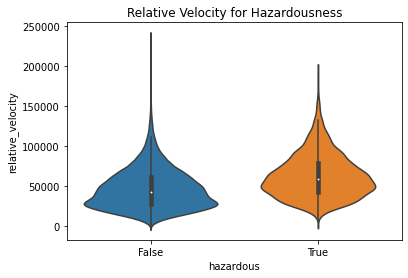

In [5]:
# Violin plots for both hazardous types looking at relative velocity
sns.violinplot(data=neos, y='relative_velocity', x='hazardous').set(title='Relative Velocity for Hazardousness')

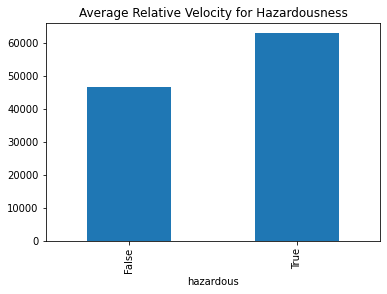

Hazardous NEOs on average had a 35.0% higher relative velocity.


In [6]:
# plot mean relative velocity per hazardousness
neos.groupby('hazardous')['relative_velocity'].mean().plot.bar(title='Average Relative Velocity for Hazardousness')
plt.show()
neos.groupby('hazardous')['relative_velocity'].mean().round(2)
rv_haz = neos.groupby('hazardous')['relative_velocity'].mean()[1].round(2)
rv_non = neos.groupby('hazardous')['relative_velocity'].mean()[0].round(2)

percentage_increase = ((rv_haz - rv_non) / rv_non * 100).round()
print(f'Hazardous NEOs on average had a {percentage_increase}% higher relative velocity.')

hazardous
False    236786.78
True     187478.68
Name: relative_velocity, dtype: float64

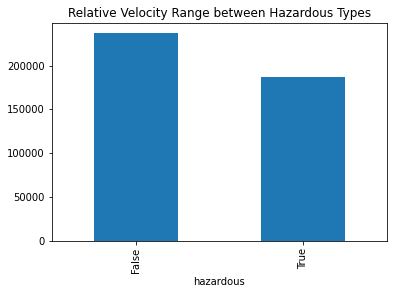

In [7]:
# calculate range for relatively velocity
rv_maximum = neos.groupby('hazardous')['relative_velocity'].max()
rv_minimum = neos.groupby('hazardous')['relative_velocity'].min()
rv_range = rv_maximum - rv_minimum
rv_range.plot.bar(title='Relative Velocity Range between Hazardous Types')
rv_range.round(2)

[Text(0.5, 1.0, 'Absolute Magnitude for Hazardousness')]

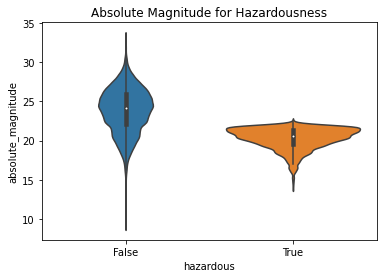

In [8]:
# Violin plots for both hazardous types looking at absolute magnitude
sns.violinplot(data=neos, y='absolute_magnitude', x='hazardous').set(title='Absolute Magnitude for Hazardousness')

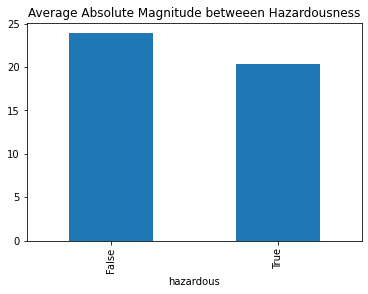

hazardous
False    23.87
True     20.31
Name: absolute_magnitude, dtype: float64

In [9]:
# plot mean absolute magnitude per hazardousness
neos.groupby('hazardous')['absolute_magnitude'].mean().plot.bar(title='Average Absolute Magnitude betweeen Hazardousness')
plt.show()
neos.groupby('hazardous')['absolute_magnitude'].mean().round(2)

hazardous
False    23.97
True      8.36
Name: absolute_magnitude, dtype: float64

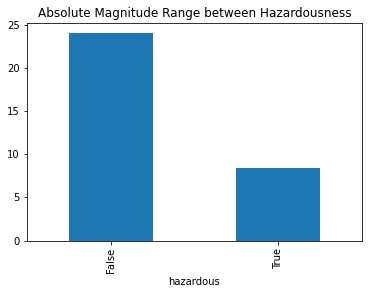

In [10]:
# calculate range for absolute magnitude
absmag_maximum = neos.groupby('hazardous')['absolute_magnitude'].max()
abgmag_minimum = neos.groupby('hazardous')['absolute_magnitude'].min()
absmag_range = absmag_maximum - abgmag_minimum
absmag_range.plot.bar(title='Absolute Magnitude Range between Hazardousness')
absmag_range.round(2)

The estimated minimum diameter on average is 164.0% larger for hazardous NEOs.

The average estimated minimum diameter for hazardous NEOs is 0.29km.
The average estimated minimum diameter for non-hazardous NEOs is 0.11km.

The maximum estimated minimum diameter for hazardous NEOs is 4.14km.
The maximum estimated minimum diameter for non-hazardous NEOs is 37.89km.


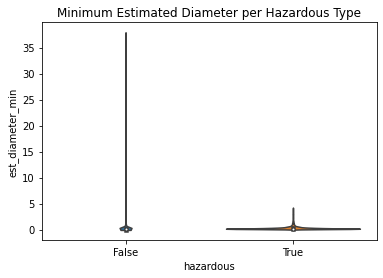

In [11]:
# Visualize distribution of NEO min size
sns.violinplot(data=neos, y='est_diameter_min', x='hazardous').set(title='Minimum Estimated Diameter per Hazardous Type')

haz_min_diam_mean = neos.groupby('hazardous')['est_diameter_min'].mean()[1].round(2)
non_min_diam_mean = neos.groupby('hazardous')['est_diameter_min'].mean()[0].round(2)
percent_change_min_diam_mean = ((haz_min_diam_mean - non_min_diam_mean) / non_min_diam_mean * 100).round()

haz_min_diam_max = neos.groupby('hazardous')['est_diameter_min'].max()[1].round(2)
non_min_diam_max = neos.groupby('hazardous')['est_diameter_min'].max()[0].round(2)

print(f'The estimated minimum diameter on average is {percent_change_min_diam_mean}% larger for hazardous NEOs.\n')
print(f'The average estimated minimum diameter for hazardous NEOs is {haz_min_diam_mean}km.')
print(f'The average estimated minimum diameter for non-hazardous NEOs is {non_min_diam_mean}km.\n')

print(f'The maximum estimated minimum diameter for hazardous NEOs is {haz_min_diam_max}km.')
print(f'The maximum estimated minimum diameter for non-hazardous NEOs is {non_min_diam_max}km.')

The estimated maximum diameter on average is 175.0% larger for hazardous NEOs.

The maximum estimated maximum diameter for hazardous NEOs is 9.25km.
The maximum estimated maximum diameter for non-hazardous NEOs is 84.73km.


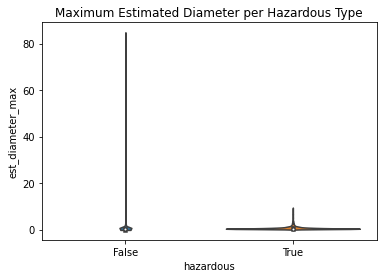

In [12]:
# Visualize distribution of NEO max size
sns.violinplot(data=neos, y='est_diameter_max', x='hazardous').set(title='Maximum Estimated Diameter per Hazardous Type')

haz_max_diam_mean = neos.groupby('hazardous')['est_diameter_max'].mean()[1].round(2)
non_max_diam_mean = neos.groupby('hazardous')['est_diameter_max'].mean()[0].round(2)
percent_change_max_diam_mean = ((haz_max_diam_mean - non_max_diam_mean) / non_max_diam_mean * 100).round()

haz_max_diam_max = neos.groupby('hazardous')['est_diameter_max'].max()[1].round(2)
non_max_diam_max = neos.groupby('hazardous')['est_diameter_max'].max()[0].round(2)

print(f'The estimated maximum diameter on average is {percent_change_max_diam_mean}% larger for hazardous NEOs.\n')


print(f'The maximum estimated maximum diameter for hazardous NEOs is {haz_max_diam_max}km.')
print(f'The maximum estimated maximum diameter for non-hazardous NEOs is {non_max_diam_max}km.')

[Text(0.5, 1.0, 'Absolute Magnitude vs. Relative Velocity')]

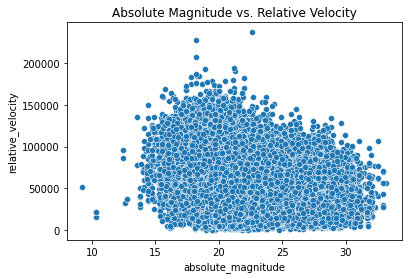

In [13]:
# plot relative velocity and absolute magnitude
sns.scatterplot(x=neos['absolute_magnitude'], y=neos['relative_velocity']).set(title='Absolute Magnitude vs. Relative Velocity')

### Exploratory Analysis Findings
1. It's possible that a higher relative velocity may be an indication of a more hazardous NEO. Although the NEOs not labeled as hazardous had a larger range than the hazardous NEOs, the hazardous NEOs were on average 35% faster in relative velocity than non-hazardous NEOs. 

2. Pertaining to absolute magnitude, the hazardous labeled NEO had a much tighter distribution with most absolute magnitudes lying very close to the mean. The non-hazardous NEOs had a higher absolute magnitude on average but also had a much larger range which could explain the higher average. 

3. Using the estimated minimum diameter, NEOs that are hazardous are on average 164% larger than non-hazardous NEOs. Using the estimated maximum diameter, NEOs that are hazardous are similarly on average 175% larger than non-hazardous NEOs. For both parameters, non-hazardous NEOs had much larger ranges and extremely large outliers. Even though the distribution for hazardous NEOs was much tighter, the average remained higher which is much more compelling.

4. There certainly appears to be a moderate negative correlation between absolute magnitude and relative velocity. As absolute magnitude increases, relative velocity appears to decrease slightly.

### Feature Engineering

- I plan to drop the `orbiting_body` and `sentry_object` columns as they have the same value for each row in both columns respectively.
- I'll also drop `id` as it is a numerical value that to model may think is of relevance, when indeed it is not.
- I'd like to take the average of `est_diameter_min` and `est_diameter_max` and put those values into an `est_diameter` column. 
- I'd like to try to create a function that extracts the year out of `name` since it's possible that year could have an affect on where NEOs and other planets may be in relation to Earth.

In [14]:
# drop `orbiting_body`, `sentry_object` and `id` columns and display head to confirm
neos = neos.drop(columns=['orbiting_body', 'sentry_object', 'id'])
neos.head()

,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [15]:
# combine `est_diameter_min` and `est_diameter_max` into one column and drop after
# display to confirm
neos['est_diameter'] = (neos['est_diameter_min'] + neos['est_diameter_max']) / 2
neos = neos.drop(columns=['est_diameter_min', 'est_diameter_max'])
neos.head()

,name,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter
0,162635 (2000 SS164),13569.249224,5.483974e+07,16.73,False,1.938843
1,277475 (2005 WK4),73588.726663,6.143813e+07,20.00,True,0.430073
2,512244 (2015 YE18),114258.692129,4.979872e+07,17.83,False,1.168268
3,(2012 BV13),24764.303138,2.543497e+07,22.20,False,0.156150
4,(2014 GE35),42737.733765,4.627557e+07,20.09,True,0.412613


In [16]:
# Find year value in `name` column and move to new `year` column

# Function takes in a name_value and finds the year.
# Converts year into integer and returns in.
def find_year(name_value):
    try:
        new_value = ""
        start_idx = name_value.find("(") + 1 
        end_idx = start_idx + 4
        new_value = name_value[start_idx : end_idx]
        new_value = int(new_value)
        return new_value
    except:
        return None
    
# Example to test function
print(find_year("277475 (2015 WK4)"))  # should return -> 2015
print(type(find_year("277475 (2015 WK4)")))     # should return -> <class 'int'>

# apply function to `name` column and create new column `year
neos['year'] = neos['name'].apply(find_year)

# drop `name` column
neos = neos.drop(columns=['name'])

# Running this on the entire column revealed exactly one row not in the correct format which is why
# I included the try except blocks and returned a null value.
# Considering I have plenty of data, I will drop it via dropna() method.
neos = neos.dropna()
neos.head()

2015
<class 'int'>


,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter,year
0,13569.249224,5.483974e+07,16.73,False,1.938843,2000.0
1,73588.726663,6.143813e+07,20.00,True,0.430073,2005.0
2,114258.692129,4.979872e+07,17.83,False,1.168268,2015.0
3,24764.303138,2.543497e+07,22.20,False,0.156150,2012.0
4,42737.733765,4.627557e+07,20.09,True,0.412613,2014.0


### Train/Test Split

The dataset contains just over 90,000 datapoints. I will randomly select 40,000 (44%) for training and 40,000 (44%)for testing. I'll then reserve the remaining 10,000+ (12%) for my golden holdout.

In [17]:
# Perform Train/Test split
class_col = ['hazardous']
random_seed = 1234

X_train, X_test, y_train, y_test = train_test_split(neos.drop(columns=class_col), neos[class_col],
                                                   test_size=0.44, train_size= 0.44, random_state=random_seed, stratify=neos[class_col])

In [18]:
# Check dimensions of X
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (39965, 5)


,relative_velocity,miss_distance,absolute_magnitude,est_diameter,year
34562,42406.355739,5.642311e+07,18.80,0.747382,2002.0
60710,90529.584612,4.841497e+07,22.10,0.163509,2016.0
60038,48660.896691,5.387454e+07,24.50,0.054143,2019.0
60732,42865.147683,2.974191e+07,28.39,0.009027,2021.0
16182,60468.602044,6.842384e+07,24.50,0.054143,2001.0



On X test: 
X test dimensions:  (39966, 5)


,relative_velocity,miss_distance,absolute_magnitude,est_diameter,year
62630,83692.581105,7.322291e+07,20.40,0.357720,2013.0
60574,52116.610106,1.725368e+06,22.50,0.136001,2013.0
24324,29408.962053,6.556767e+06,24.60,0.051706,2010.0
47507,42568.799723,3.970700e+07,21.80,0.187734,2011.0
83376,15830.841648,3.758479e+06,26.02,0.026887,2021.0


In [19]:
# Check dimensions of Y
# Y Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (39965, 1)


,hazardous
34562,True
60710,False
60038,False
60732,False
16182,False



On y test: 
y test dimensions:  (39966, 1)


,hazardous
62630,False
60574,False
24324,False
47507,False
83376,False


### Pipeline

Considering my data have no missing values, I won't need any imputation pipelines. Since my only non-numerical column will be a binary column value there will be no use for one hot encoding. However, a few features had some extreme outliers so I will consider using a scaler such as `RobustScaler` or `StandardScaler` to normalize the data. The problem I'm solving is a binary classification problem, so I will first implement with a Logistic Regression classification model.

In [20]:
# Build pipe for handling numerical data
# No categorical pipes needed since only categorical column is binary

num_pipeline = Pipeline(steps=[('scale_num', StandardScaler())])

In [21]:
# Establish preprocessing pipe via column transformer
num_cols = ['relative_velocity', 'miss_distance', 'absolute_magnitude', 'est_diameter', 'year']

preproc = ColumnTransformer([('num_pipe', num_pipeline, num_cols)],
                             remainder='passthrough')

In [22]:
# Generate pipeline with logistic regression model
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  ['relative_velocity',
                                                   'miss_distance',
                                                   'absolute_magnitude',
                                                   'est_diameter', 'year'])])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

### Model Fitting and Evaluation

Since I'm looking to see if an NEO is hazardous, this will be a binary classification problem. I have one primary assumption for feature importance:
- `miss_distance` will most likely be the most important feature considering that we can assume that the closer an NEO is to Earth, the more potential dangerous it is.

I anticipate the model to perform well (90%+) since there are some general trends with all of the numerical features. 

## Performance Metrics

Given that I'll have the correct "hazardous" labels for the test dataset, I'll be able to see the accuracy of the model very clearly. Simply put, if the values match the prediction will be considered correct. Considering that I have over 90,000 datapoints available to use I may also increase the training and test dataset sizes if I see that I don't have enough data to make an accurate prediction but I hope to only need 10,000 for each dataset.